In [1]:
# Setup: core libraries and ML utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # non-linear tree-based regressor
from sklearn.metrics import mean_squared_error, r2_score  # regression metrics (MSE, R^2)
import seaborn as sns

In [2]:
# len function example
m = "Oren"
len(m)

4

In [3]:
# Generate synthetic telecom traffic data for 2023 at hourly resolution
np.random.seed(42) # ensure reproducible randomness
dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='H') # hourly timestamps across 2023
n_samples = len(dates) # number of rows to simulate

/tmp/ipython-input-2100263796.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='H') # hourly timestamps across 2023


In [4]:
# Create realistic traffic pattern drivers derived from the timestamp
hour = dates.hour # hour-of-day [0..23] to capture diurnal patterns
day_of_week = dates.dayofweek # weekday index (Mon=0..Sun=6) for weekday/weekend effects
day_of_year = dates.dayofyear # day number in the year [1..365] for slow seasonal drift

In [5]:
# Base traffic composed of daily, weekly, annual cycles plus random noise
base_traffic = (
    50 +                                        # baseline load (Gbps) present 24/7
    20 * np.sin(2 * np.pi * hour / 24) +        # diurnal cycle within each day
    10 * np.sin(2 * np.pi * day_of_week / 7) +  # weekday vs weekend differences
    5  * np.sin(2 * np.pi * day_of_year / 365) +# annual seasonality
    np.random.normal(0, 5, n_samples)           # additive Gaussian noise for realism
)

In [6]:
# Example: generate a small vector of random integers (not used downstream)
rannums = np.random.randint(21, 51, 10) # 10 random integers between 21 and 50
print(rannums) # show sample output

[32 23 33 35 34 44 29 33 43 42]


In [7]:
# Add a business-hours boost (simulate office traffic 9am–5pm on weekdays)
business_hours = (hour >= 9) & (hour <= 17) & (day_of_week < 5) # True during M–F, 9–17
base_traffic += business_hours * 15 # +15 Gbps wherever mask is True

In [8]:
# Assemble the modeling DataFrame
traffic_data = pd.DataFrame({
    'timestamp': dates,                           # time axis (useful for plotting and grouping)
    'hour': hour,                                 # engineered feature: hour-of-day
    'day_of_week': day_of_week,                   # engineered feature: day index 0..6
    'is_weekend': day_of_week >= 5,               # engineered feature: weekend flag (Sat/Sun)
    'is_business_hours': business_hours,          # engineered feature: office-hours flag
    'traffic_gbps': np.maximum(base_traffic, 0)   # target; clamp at 0 to avoid negatives
})

In [9]:
# Feature engineering: simple lags and a rolling average to help the model
traffic_data['traffic_lag_1h'] = traffic_data['traffic_gbps'].shift(1) # previous hour
traffic_data['traffic_lag_24h'] = traffic_data['traffic_gbps'].shift(24) # same hour yesterday
traffic_data['traffic_rolling_7d'] = traffic_data['traffic_gbps'].rolling(
    window=24*7, center=True   # 7 days of hours; centered to capture local trend symmetrically
).mean()                       # rolling mean introduces NaNs at both ends

In [10]:
# Remove rows with NaNs created by lag/rolling features (edge effects)
traffic_data = traffic_data.dropna()  # drops first/last ~3.5 days due to centered rolling window

print("Dataset shape:", traffic_data.shape) # (rows, columns) after cleanup
print("\nFirst few rows:")
print(traffic_data.head()) # quick sanity check of feature construction

Dataset shape: (8570, 9)

First few rows:
             timestamp  hour  day_of_week  is_weekend  is_business_hours  \
84 2023-01-04 12:00:00    12            2       False               True   
85 2023-01-04 13:00:00    13            2       False               True   
86 2023-01-04 14:00:00    14            2       False               True   
87 2023-01-04 15:00:00    15            2       False               True   
88 2023-01-04 16:00:00    16            2       False               True   

    traffic_gbps  traffic_lag_1h  traffic_lag_24h  traffic_rolling_7d  
84     71.050823       77.678321        70.680542           54.166101  
85     67.408125       71.050823        66.971737           54.147588  
86     69.670302       67.408125        57.544738           54.132844  
87     62.594911       69.670302        52.953244           54.090667  
88     55.123982       62.594911        59.818534           54.024632  


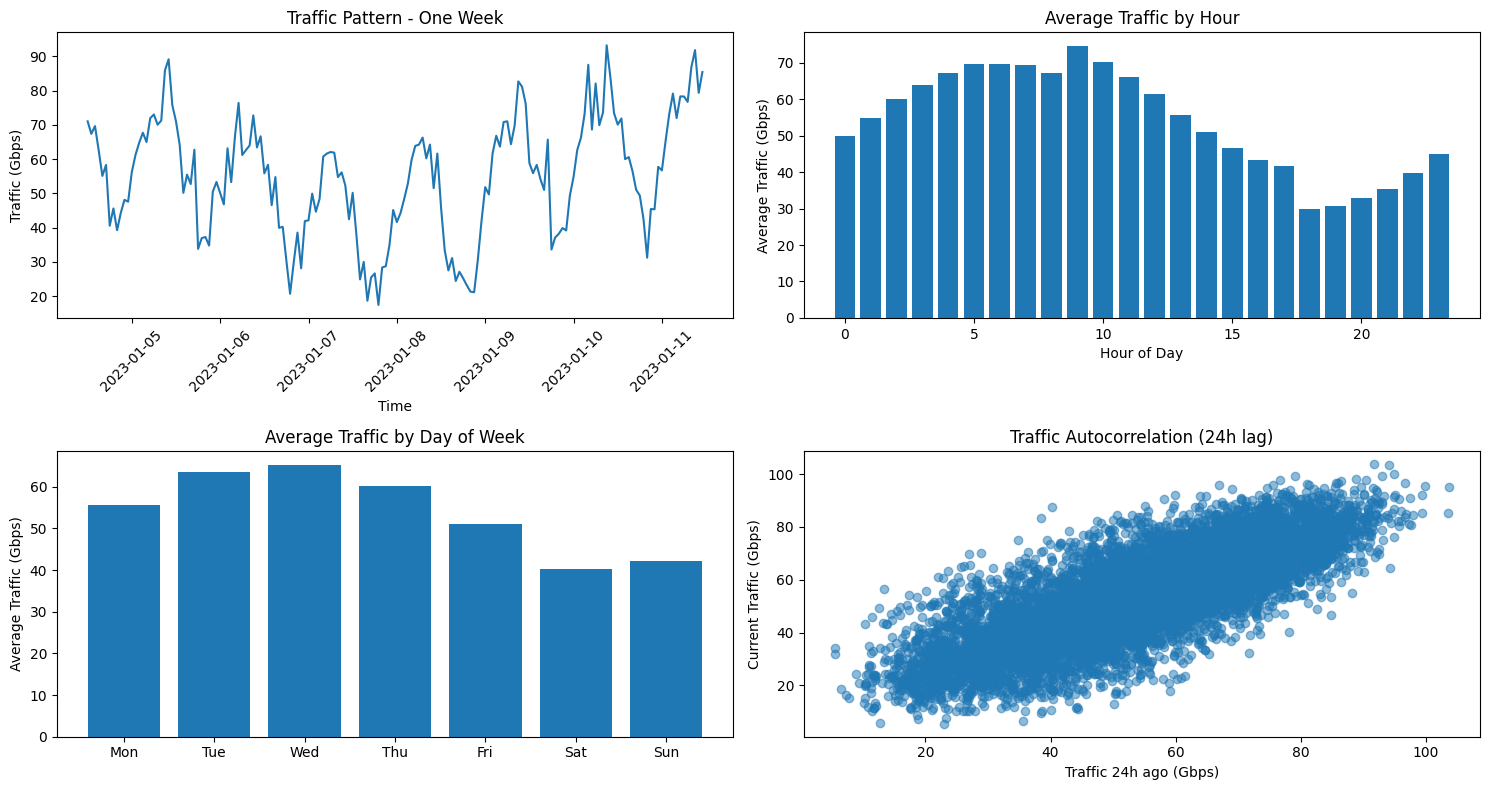

In [11]:
# Quick EDA: visualize key traffic patterns and simple autocorrelation
plt.figure(figsize=(15, 8))  # draw a 2x2 grid of subplots

# (1) One-week time series slice
plt.subplot(2, 2, 1)
plt.plot(traffic_data['timestamp'][:24*7], traffic_data['traffic_gbps'][:24*7])
plt.title('Traffic Pattern - One Week')
plt.xlabel('Time')
plt.ylabel('Traffic (Gbps)')
plt.xticks(rotation=45)  # rotate labels for readability

# (2) Average traffic by hour-of-day across the year
plt.subplot(2, 2, 2)
hourly_avg = traffic_data.groupby('hour')['traffic_gbps'].mean()  # mean by hour index
plt.bar(hourly_avg.index, hourly_avg.values)
plt.title('Average Traffic by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic (Gbps)')

# (3) Average traffic by day-of-week
plt.subplot(2, 2, 3)
daily_avg = traffic_data.groupby('day_of_week')['traffic_gbps'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']  # human-friendly x labels
plt.bar(days, daily_avg.values)
plt.title('Average Traffic by Day of Week')
plt.ylabel('Average Traffic (Gbps)')

# (4) Simple autocorrelation: value vs. its 24h lag
plt.subplot(2, 2, 4)
plt.scatter(traffic_data['traffic_lag_24h'], traffic_data['traffic_gbps'], alpha=0.5)
plt.title('Traffic Autocorrelation (24h lag)')
plt.xlabel('Traffic 24h ago (Gbps)')
plt.ylabel('Current Traffic (Gbps)')

plt.tight_layout() # reduce overlap and whitespace
plt.show() # render the figure

In [12]:
# Prepare features (X) and target (y) for regression
feature_columns = [
    'hour', 'day_of_week', 'is_weekend', 'is_business_hours',
    'traffic_lag_1h', 'traffic_lag_24h', 'traffic_rolling_7d'
]

X = traffic_data[feature_columns] # design matrix
y = traffic_data['traffic_gbps'] # continuous target variable

In [13]:
# Chronological train/test split (no shuffling for time-series sanity)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,        # last 25% of timeline becomes the test period
    random_state=42,       # reproducibility (affects only if shuffle=True)
    shuffle=False          # keep temporal order to avoid leakage
)

In [14]:
# Train a Random Forest Regressor (handles nonlinearities and interactions)
rf_model = RandomForestRegressor(
    n_estimators=100,  # number of trees in the ensemble
    max_depth=10,      # limit tree depth to curb overfitting
    random_state=42,   # reproducible bootstrapping/splits
    n_jobs=-1          # parallelize across all available CPU cores
)

rf_model.fit(X_train, y_train)  # learn mapping from features to Gbps traffic

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

In [15]:
# Make predictions for inspection on both splits
y_pred_train = rf_model.predict(X_train) # in-sample predictions
y_pred_test  = rf_model.predict(X_test) # out-of-sample predictions

In [16]:
# Evaluate model performance using MSE and R^2 on train/test
train_mse = mean_squared_error(y_train, y_pred_train) # smaller is better
test_mse  = mean_squared_error(y_test,  y_pred_test)
train_r2  = r2_score(y_train, y_pred_train) # closer to 1 is better
test_r2   = r2_score(y_test,  y_pred_test)

print(f"\nModel Performance:")
print(f"Training MSE: {train_mse:.2f}")
print(f"Testing MSE: {test_mse:.2f}")
print(f"Training R²: {train_r2:.3f}")
print(f"Testing R²: {test_r2:.3f}")


Model Performance:
Training MSE: 17.27
Testing MSE: 35.31
Training R²: 0.947
Testing R²: 0.891


In [17]:
# Inspect learned feature importances (normalized contributions that sum to 1)
feature_importance = pd.DataFrame({
    'feature': feature_columns,                 # feature names
    'importance': rf_model.feature_importances_ # impurity-based importance per feature
}).sort_values('importance', ascending=False)   # rank features by influence

print(f"\nFeature Importance:")
print(feature_importance) # display as a sorted table


Feature Importance:
              feature  importance
4      traffic_lag_1h    0.812238
0                hour    0.080503
5     traffic_lag_24h    0.034052
1         day_of_week    0.029149
6  traffic_rolling_7d    0.023352
3   is_business_hours    0.018506
2          is_weekend    0.002199


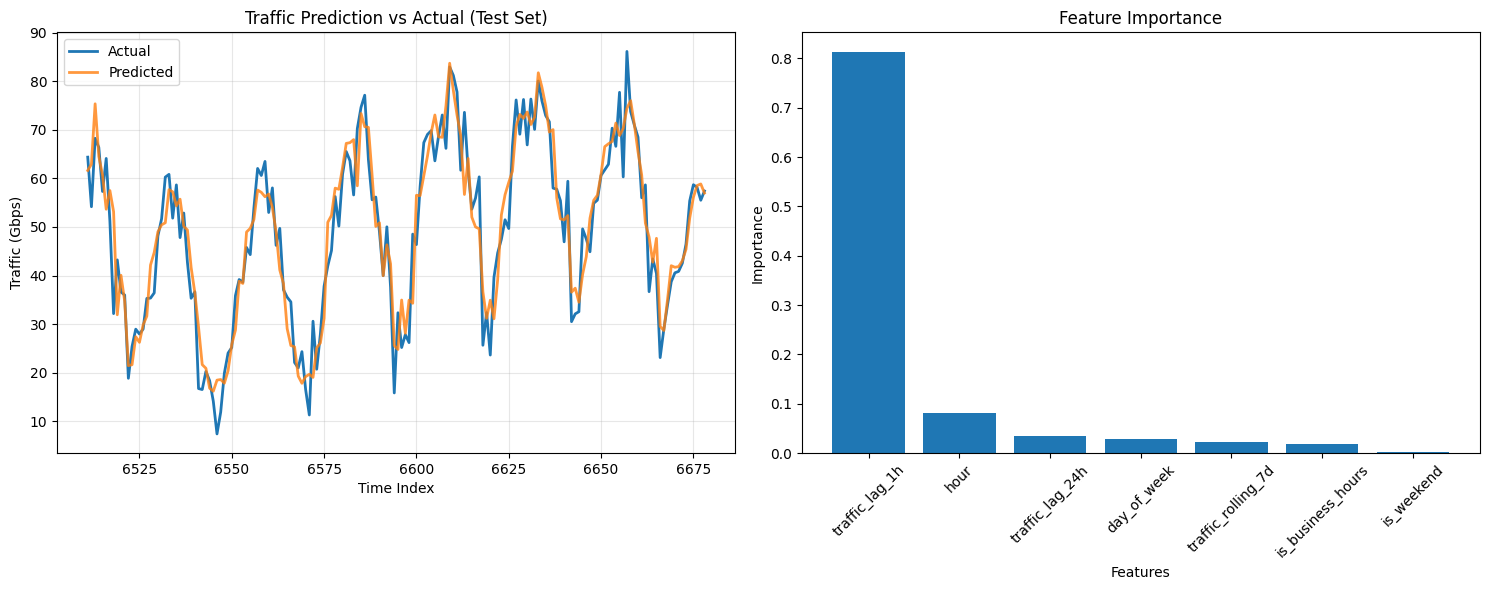

In [18]:
# Visual diagnostics: compare predictions vs actuals and plot importances
plt.figure(figsize=(15, 6))

# Left subplot: one week from the test period for side-by-side comparison
test_indices = X_test.index[:168] # first 168 hours (~7 days) within the test slice

plt.subplot(1, 2, 1)
plt.plot(test_indices, y_test.loc[test_indices], label='Actual', linewidth=2)
plt.plot(test_indices, y_pred_test[:len(test_indices)],
         label='Predicted', linewidth=2, alpha=0.8)
plt.title('Traffic Prediction vs Actual (Test Set)')
plt.xlabel('Time Index') # using integer indices here for simplicity
plt.ylabel('Traffic (Gbps)')
plt.legend()
plt.grid(True, alpha=0.3) # light grid for readability

# Right subplot: feature importance bars from the trained forest
plt.subplot(1, 2, 2)
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()